In [1]:
import cvxpy as cp 
import datetime as dt 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
from pypfopt import (expected_returns, risk_models, plotting, EfficientFrontier, objective_functions, 
                     black_litterman, BlackLittermanModel, DiscreteAllocation, HRPOpt)
import seaborn as sns 
import yfinance as yf 

plt.style.use("bmh")

# Advanced MVO - custom objectives

## Get Data

In [2]:
tickers = ["BLK", "BAC", "AAPL", "TM", "WMT",
           "JD", "INTU", "MA", "UL", "CVS",
           "DIS", "AMD", "NVDA", "PBI", "TGT"]
data = yf.download(tickers, interval='1d', period='5y')['Adj Close']

[*********************100%***********************]  15 of 15 completed


In [3]:
data.head()

,AAPL,AMD,BAC,BLK,CVS,DIS,INTU,JD,MA,NVDA,PBI,TGT,TM,UL,WMT
Date,,,,,,,,,,,,,,,
2017-05-08,36.116474,10.04,21.598577,337.955719,70.338860,106.698044,121.523048,38.549999,113.469398,25.385944,12.254909,50.087635,110.190002,44.628666,69.021172
2017-05-09,36.347797,10.18,21.616602,336.294220,70.382271,107.320496,122.062439,38.529999,113.274796,25.427937,12.347692,50.769459,108.459999,44.568878,69.565216
2017-05-10,36.175484,10.79,21.769850,337.858490,70.243408,105.012650,122.409172,39.320000,113.508331,29.960697,12.479132,51.057907,105.809998,44.995945,70.012497
2017-05-11,36.488342,11.07,21.697739,338.388794,71.406319,104.936028,122.206909,39.759998,113.391556,31.247658,12.239447,49.003704,106.839996,45.106976,69.492188
2017-05-12,36.997936,11.26,21.634634,340.377380,69.609879,105.041374,121.850540,40.560001,113.975410,31.591011,12.123468,48.776440,106.459999,45.072823,69.108810


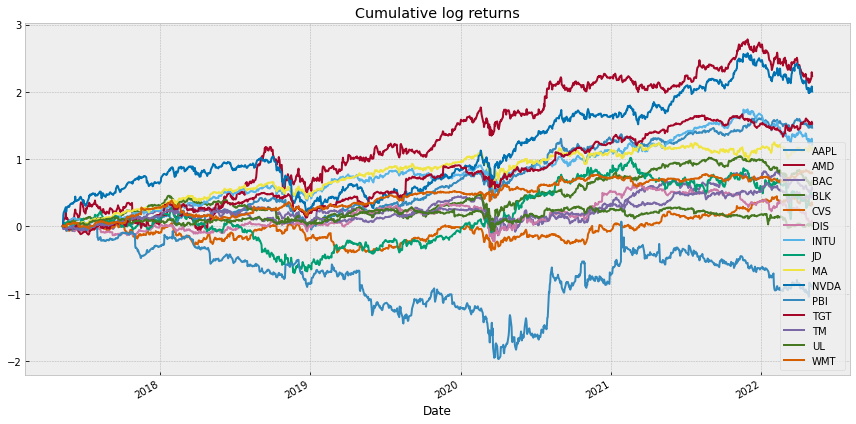

In [4]:
data.apply(np.log).diff(1).cumsum().plot(figsize=(12,6), title='Cumulative log returns')
plt.tight_layout()
plt.show()

## Returns / Covariance

In [5]:
mu = expected_returns.capm_return(data)
S = risk_models.semicovariance(data)

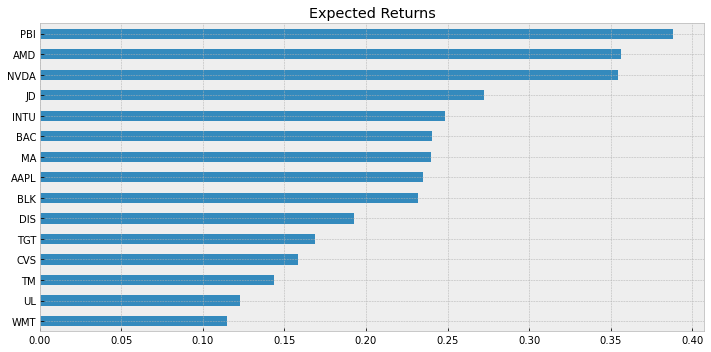

In [6]:
mu.sort_values().plot(kind='barh', figsize=(10,5))
plt.title("Expected Returns")
plt.tight_layout()
plt.show()

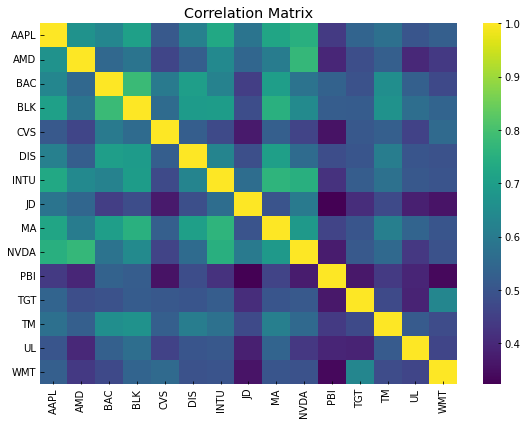

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(risk_models.cov_to_corr(S), ax=ax, cmap='viridis')
ax.set_title("Correlation Matrix")
plt.tight_layout()
plt.show()

## Min volatility with a transaction cost objective

In [8]:
# initialize equal weights
init_weights = np.full(shape=(len(tickers),), fill_value=1/len(tickers))
init_weights

array([0.06666667, 0.06666667, 0.06666667, 0.06666667, 0.06666667,
       0.06666667, 0.06666667, 0.06666667, 0.06666667, 0.06666667,
       0.06666667, 0.06666667, 0.06666667, 0.06666667, 0.06666667])

In [9]:
# pay transaction cost when weights change
# high transaction cost --> weights tend to stay unchanged

# 1% commision
ef1 = EfficientFrontier(mu, S)
ef1.add_objective(objective_functions.transaction_cost, w_prev=init_weights, k=0.01) 
ef1.min_volatility()
weights1 = ef1.clean_weights()

# 0.1% commision
ef2 = EfficientFrontier(mu, S)
ef2.add_objective(objective_functions.transaction_cost, w_prev=init_weights, k=0.001) 
ef2.min_volatility()
weights2 = ef2.clean_weights()

# 0.1% commision with L2-reg
ef3 = EfficientFrontier(mu, S)
ef3.add_objective(objective_functions.transaction_cost, w_prev=init_weights, k=0.001) 
ef3.add_objective(objective_functions.L2_reg, gamma=0.05)
ef3.min_volatility()
weights3 = ef3.clean_weights()

In [10]:
adjusted_weights1 = pd.DataFrame.from_dict(weights1, orient='index', columns=['weights'])
adjusted_weights1['description'] = "1% transaction cost"

adjusted_weights2 = pd.DataFrame.from_dict(weights2, orient='index', columns=['weights'])
adjusted_weights2['description'] = "0.1% transaction cost"

adjusted_weights3 = pd.DataFrame.from_dict(weights3, orient='index', columns=['weights'])
adjusted_weights3['description'] = "0.1% transaction cost with L2-reg"

init_weights = pd.DataFrame(data=init_weights, index=adjusted_weights1.index, columns=['weights'])
init_weights['description'] = "initial weights"

total_weights = pd.concat([adjusted_weights1, adjusted_weights2, adjusted_weights3, init_weights], axis=0)

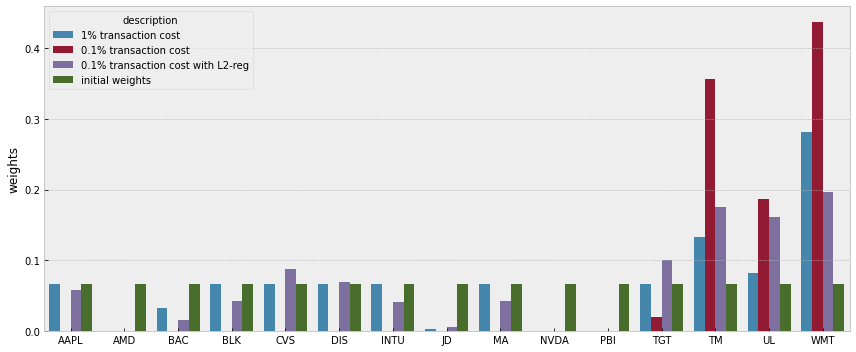

In [11]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(data=total_weights, y='weights', x=total_weights.index, hue='description', ax=ax)
plt.tight_layout()
plt.show()

## Custom convex objectives

minimise the logarithmic-barrier function suggested in the paper "60 Years of Portfolio Optimization", by Kolm et al (2014):
\begin{equation}\label{eq:}
f(w,S,k) = w^{T}Sw - k\sum_{k=1}^{n} \ln w
\end{equation}
* use `cvxpy` for convex optimization

quad_form(x, P) == $x^T P x$

In [12]:
def logarithmic_barrier_objective(w, cov_mat, k=1):
    log_sum = cp.sum(cp.log(w))
    variance = cp.quad_form(w, cov_mat) 
    return variance - k*log_sum

In [13]:
ef = EfficientFrontier(mu, S, weight_bounds=(0.01, 0.2))

# limit specific weights
wmt_index = data.columns.get_loc('WMT')
ef.add_constraint(lambda w: w[wmt_index] <= 0.15)

# add convex objective
ef.convex_objective(logarithmic_barrier_objective, cov_mat=S, k=0.001)
weights = ef.clean_weights()

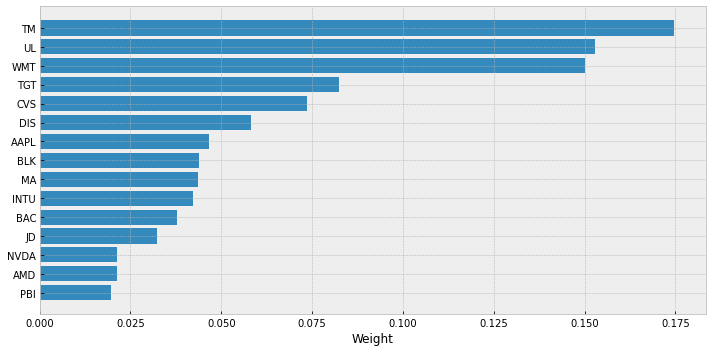

In [14]:
ax = plotting.plot_weights(weights)
ax.figure.set_size_inches(10,5)
plt.tight_layout()
plt.show()

## Custom nonconvex objectives
* not encouraged
* not using `cvxpy`
* use `scipy` to add constraints

In [15]:
# Deviation Risk Parity objective from Kolm et al (2014)

def deviation_risk_parity(w, cov_matrix):
    diff = w * np.dot(cov_matrix, w) - (w * np.dot(cov_matrix, w)).reshape(-1, 1)
    return (diff ** 2).sum().sum()

In [16]:
ef = EfficientFrontier(mu, S, weight_bounds=(0.01, 0.2))
ef.nonconvex_objective(deviation_risk_parity, S) # add nonconvex obj
weights = ef.clean_weights()

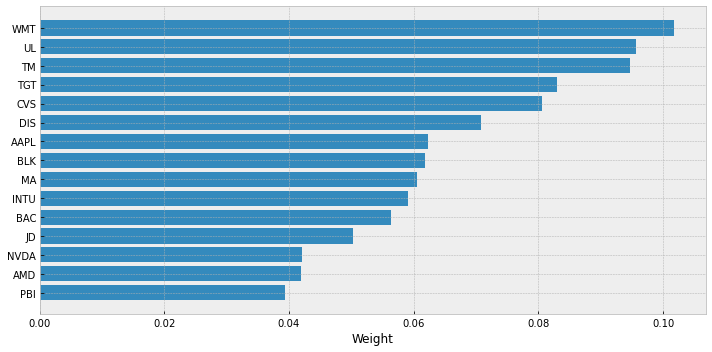

In [17]:
ax = plotting.plot_weights(weights)
ax.figure.set_size_inches(10,5)
plt.tight_layout()
plt.show()

In [18]:
ef = EfficientFrontier(mu, S)
wmt_index = data.columns.get_loc('WMT')
aapl_index = data.columns.get_loc('AAPL')
nvda_index = data.columns.get_loc('NVDA')

upper_bound = 0.06
lower_bound = 0.04
# use scipy constraints
# eq --> == 0
# ineq >= 0

ef.nonconvex_objective(deviation_risk_parity,
                       objective_args=S,
                       weights_sum_to_one=True,
                       constraints= [  
                           {'type': 'eq', 'fun': lambda w: w[wmt_index] - 0.12}, # WMT == 12%
                           {'type': 'ineq', 'fun': lambda w: upper_bound - w[aapl_index]}, # AAPL <= 6%
                           {'type': 'ineq', 'fun': lambda w: w[nvda_index] - lower_bound} # NVDA >= 4%
                       ])
weights = ef.clean_weights()

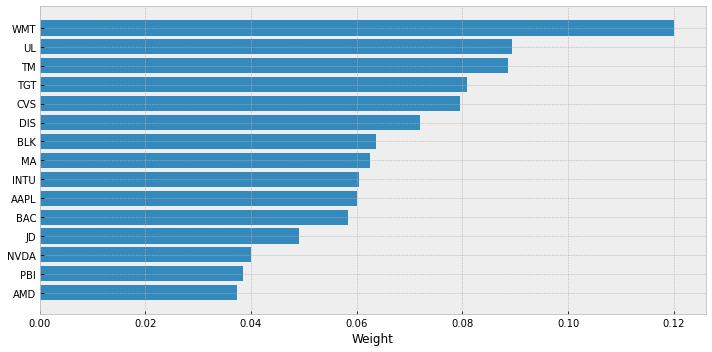

In [19]:
ax = plotting.plot_weights(weights)
ax.figure.set_size_inches(10,5)
plt.tight_layout()
plt.show()

# Black-Litterman Allocation
* prior estimated returns + views $\rightarrow$ posterior expected returns
* can provide confidence
* more stable than mean historical return


## Get data

In [20]:
tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA',
           'FB', 'NVDA', 'UNH', 'JNJ', 'WMT']
data = yf.download(tickers, period='5y', interval='1d')['Adj Close']

[*********************100%***********************]  10 of 10 completed


In [21]:
data.head()

,AAPL,AMZN,FB,GOOG,JNJ,MSFT,NVDA,TSLA,UNH,WMT
Date,,,,,,,,,,
2017-05-08,36.116474,949.039978,151.059998,934.299988,108.038383,64.354454,25.385944,61.438000,161.886475,69.021172
2017-05-09,36.347786,952.820007,150.479996,932.169983,108.003311,64.447800,25.427937,64.251999,160.772842,69.565216
2017-05-10,36.175476,948.950012,150.289993,928.780029,107.652702,64.699814,29.960697,65.043999,160.912048,70.012482
2017-05-11,36.488342,947.619995,150.039993,930.599976,107.994545,63.906361,31.247658,64.620003,160.847107,69.492210
2017-05-12,36.997921,961.349976,150.330002,932.219971,108.380257,63.831699,31.591011,64.961998,159.445740,69.108826


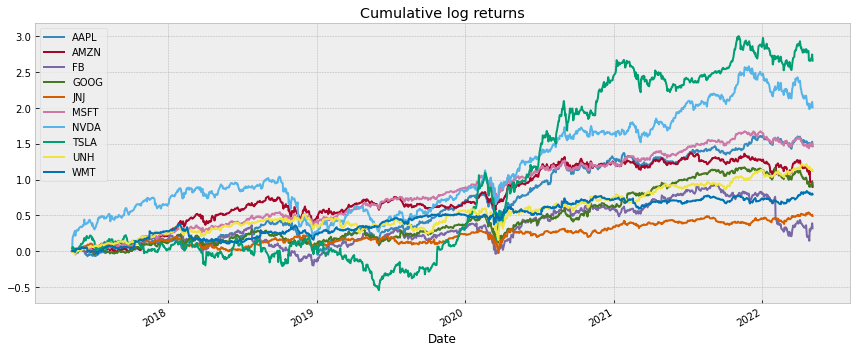

In [22]:
data.apply(np.log).diff(1).cumsum().plot(figsize=(12,5), title='Cumulative log returns')
plt.tight_layout()
plt.show()

In [23]:
# market portfolio of S&P500
market_prices = yf.download("SPY", period='5y', interval='1d')['Adj Close']
market_prices.head()

[*********************100%***********************]  1 of 1 completed


Date
2017-05-08    219.617172
2017-05-09    219.415604
2017-05-10    219.809601
2017-05-11    219.360611
2017-05-12    218.994080
Name: Adj Close, dtype: float64

In [24]:
# get Market Caps 
d0 = dt.datetime.now()
market_caps = {}
for i, t in enumerate(tickers):
    d_ticker = dt.datetime.now()
    stock = yf.Ticker(t)
    mkt_cap = stock.info['marketCap']
    market_caps[t] = mkt_cap
    print(f"{i+1} of {len(tickers)} | {t} --> {dt.datetime.now() - d_ticker}")

print("-"*30)
print(f"Total timed --> {dt.datetime.now() - d0}")
print("="*30)

market_caps

1 of 10 | AAPL --> 0:00:03.705617
2 of 10 | MSFT --> 0:00:03.688828
3 of 10 | GOOG --> 0:00:03.874057
4 of 10 | AMZN --> 0:00:03.778986
5 of 10 | TSLA --> 0:00:03.799233
6 of 10 | FB --> 0:00:09.688058
7 of 10 | NVDA --> 0:00:13.054292
8 of 10 | UNH --> 0:00:13.489684
9 of 10 | JNJ --> 0:00:12.684385
10 of 10 | WMT --> 0:00:12.932153
------------------------------
Total timed --> 0:01:20.697290


{'AAPL': 2537353904128,
 'MSFT': 2074308902912,
 'GOOG': 1535487246336,
 'AMZN': 1184371310592,
 'TSLA': 904726839296,
 'FB': 563672317952,
 'NVDA': 469592473600,
 'UNH': 465952538624,
 'JNJ': 465338368000,
 'WMT': 423682441216}

In [25]:
# covariance matrix
S = risk_models.CovarianceShrinkage(prices=data).ledoit_wolf()

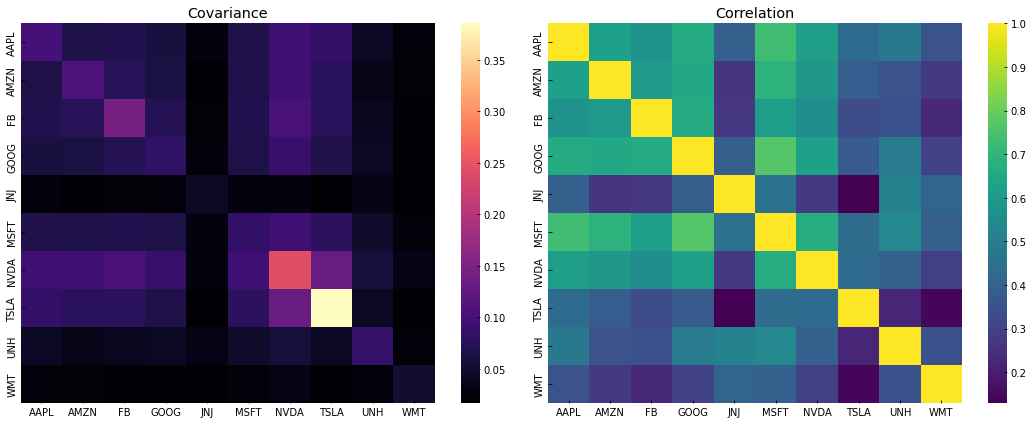

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))

sns.heatmap(S, ax=ax[0], cmap='magma')
ax[0].set_title("Covariance")

sns.heatmap(risk_models.cov_to_corr(S), cmap='viridis', ax=ax[1])
ax[1].set_title("Correlation")

plt.tight_layout()
plt.show()

## Priors

market-implied risk premium
\begin{equation*}
\delta = \frac{R-R_f}{\sigma^{2}}
\end{equation*}

market-implied returns
\begin{equation*}
\prod = \delta \Sigma w_{mkt}
\end{equation*}


In [27]:
delta = black_litterman.market_implied_risk_aversion(market_prices) # risk aversion parameter
market_prior = black_litterman.market_implied_prior_returns(market_caps, delta, S) # market-implied returns

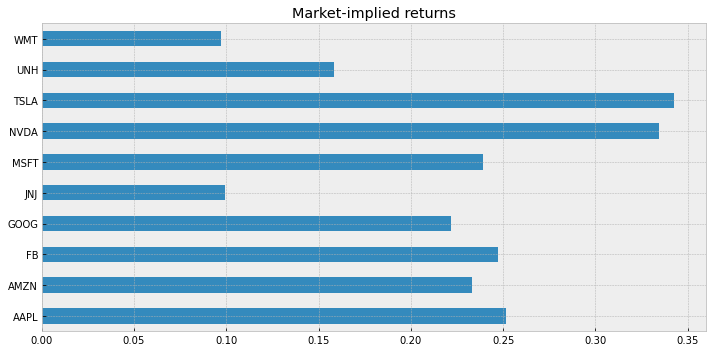

In [28]:
ax = market_prior.plot(kind='barh')
ax.figure.set_size_inches((10,5))
ax.set_title("Market-implied returns")
plt.tight_layout()
plt.show()

## Views
* can be 'Absolute' or 'Relative'
* Absolute $\rightarrow$ specify in arguments
* Relative $\rightarrow$ define our own P (view documents)

* P (picking matrix) $\rightarrow$ maps the views to asset
* Q $\rightarrow$ magnitude of each views

### Absolute views

In [29]:
# Absolute views --> just pass through dictionary
# Don't have to provide views on all assets

viewdict = {
    'AAPL': 0.1,
    'MSFT': 0.06,
    'GOOG': 0.05,
    'FB': -0.15,
    'UNH': -0.2,
    'WMT': 0.02,
}

In [30]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

### Relative views

In [31]:
S.columns

Index(['AAPL', 'AMZN', 'FB', 'GOOG', 'JNJ', 'MSFT', 'NVDA', 'TSLA', 'UNH',
       'WMT'],
      dtype='object')

In [32]:
# AAPL rise 5% (absolute)
# AMZN drop 2% (absolute)
# GOOG outperform FB by 10%
# NVDA and TSLA outperform JNJ and UNH by 15%

# define Q --> put returns views into column vector

Q = np.array([0.05, -0.02, 0.1, 0.15])

# define P --> mapping views to assets
# shape --> (#views x #assets)
# absolute views --> single 1 in ticker's order
# relative views --> positve number in outperform and negative number is underperform
# each rows sum up to 0

P = np.array([
    [1, 0, 0, 0, 0, 0, 0, 0, 0 ,0], # AAPL
    [0, 1, 0, 0, 0, 0, 0, 0, 0 ,0], # AMZN
    [0, 0, -1, 1, 0, 0, 0, 0, 0, 0], # GOOG > FB
    [0, 0, 0, 0, -0.5, 0, 0.5, 0.5, -0.5 ,0] # NVDA + TSLA > JNJ + UNH
])

In [33]:
bl = BlackLittermanModel(cov_matrix=S, pi=market_prior, Q=Q, P=P)

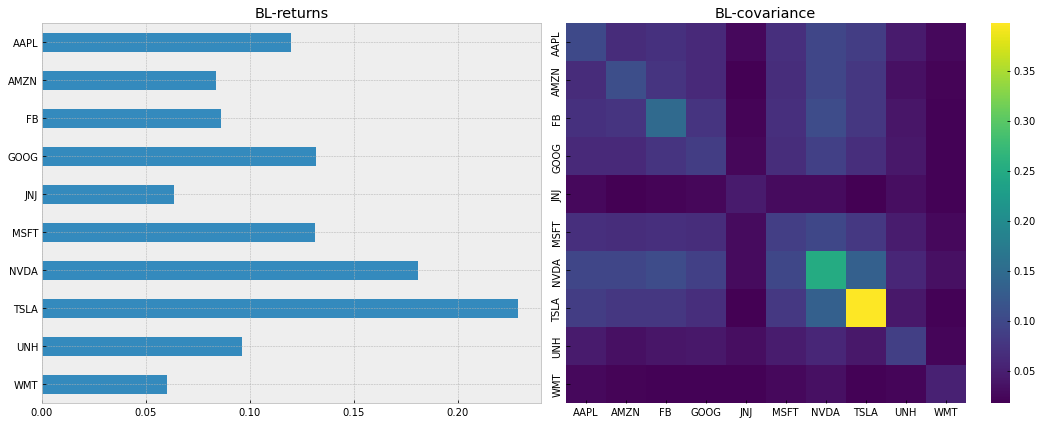

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

bl.bl_returns()[::-1].plot(kind='barh', ax=ax[0])
ax[0].set_title("BL-returns")

sns.heatmap(bl.bl_cov(), cmap='viridis', ax=ax[1])
ax[1].set_title("BL-covariance")

plt.tight_layout()
plt.show()

### View Confidences

confidence matrix / uncertainty matrix is a diagonal covariance matrix containing the variances of each view <br>
defaults to <br>
\begin{equation*}
\Omega = \tau * P \Sigma P^{T}
\end{equation*}


Idzorek's method $\rightarrow$ defines our own confidences

In [35]:
# percentage from 0 to 1
confidences = [
    0.5,
    0.2,
    0.2,
    0.7,
    0.1,
    0.4,
]

In [36]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, 
                         omega='idzorek', view_confidences=confidences)

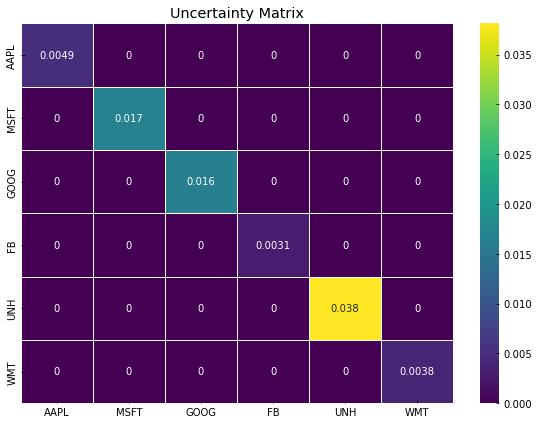

In [37]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(bl.omega, cmap='viridis', ax=ax, annot=True, linewidths=0.5)
ax.set_xticklabels(viewdict.keys())
ax.set_yticklabels(viewdict.keys())
ax.set_title("Uncertainty Matrix")
plt.tight_layout()
plt.show()

In [38]:
# lower confidences --> higher uncertainties
print('='*40)
print("Tickers ---- Confidences ---- Omega")
print('='*40)
for t, c, o in zip(viewdict.keys(), confidences, np.diag(bl.omega)):
    print(f"{t:7s} ----     {str(c):7s} ---- {o:.5f}")
print('-'*40)

Tickers ---- Confidences ---- Omega
AAPL    ----     0.5     ---- 0.00495
MSFT    ----     0.2     ---- 0.01681
GOOG    ----     0.2     ---- 0.01638
FB      ----     0.7     ---- 0.00308
UNH     ----     0.1     ---- 0.03812
WMT     ----     0.4     ---- 0.00377
----------------------------------------


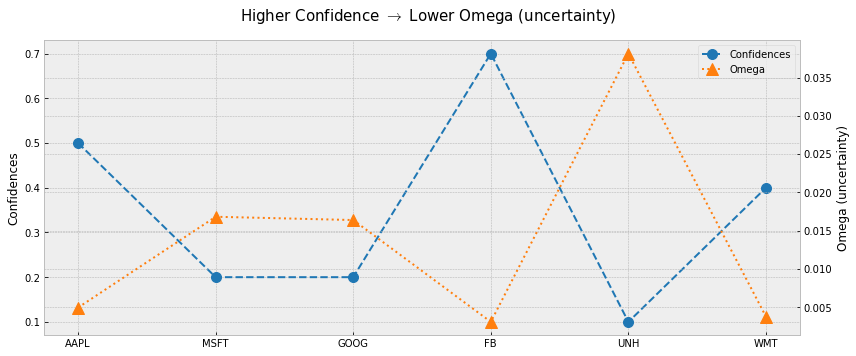

In [39]:
conf_df = pd.DataFrame(data=confidences, index=viewdict.keys(), columns=['Confidences'])
conf_df['Omega'] = np.diag(bl.omega)

fig, ax = plt.subplots(figsize=(12, 5))

line1, = ax.plot(conf_df.Confidences, marker='o', linestyle='--', 
                 label='Confidences', color='tab:blue', markersize=10)
ax.set_ylabel("Confidences")

ax2 = ax.twinx()
line2, = ax2.plot(conf_df.Omega, color='tab:orange', marker='^', 
                  linestyle=':', label='Omega', markersize=12)
ax2.set_ylabel("Omega (uncertainty)")

ax.legend(handles=[line1, line2])
fig.suptitle(r"Higher Confidence $\rightarrow$ Lower Omega (uncertainty)", fontsize=15)
plt.tight_layout()
plt.show()

### Construct uncertainty matrix

In [40]:
# specify 1 standard deviation confidence intervals
# bounds that contains true return 68% of the time
# might easier than come up with arbitrary confidences

intervals = [
    (0, 0.4),
    (0.1, 0.3),
    (0.05, 0.1),
    (-0.2, 0.1),
    (-0.05, 0.25),
    (0.01, 0.3),
]

In [41]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb) / 2
    variances.append(sigma ** 2)

In [42]:
omega = np.diag(variances)
omega 

array([[0.04    , 0.      , 0.      , 0.      , 0.      , 0.      ],
       [0.      , 0.01    , 0.      , 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.000625, 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , 0.0225  , 0.      , 0.      ],
       [0.      , 0.      , 0.      , 0.      , 0.0225  , 0.      ],
       [0.      , 0.      , 0.      , 0.      , 0.      , 0.021025]])

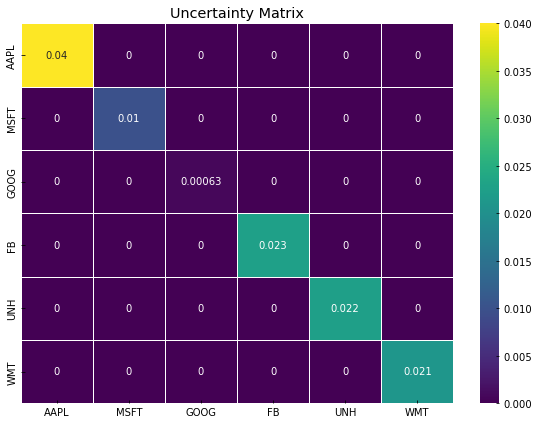

In [43]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(omega, ax=ax, cmap='viridis', annot=True, linewidths=0.5)
ax.set_xticklabels(viewdict.keys())
ax.set_yticklabels(viewdict.keys())
ax.set_title("Uncertainty Matrix")
plt.tight_layout()
plt.show()

## Posterior

In [44]:
bl = BlackLittermanModel(S, pi="market", market_caps=market_caps, risk_aversion=delta,
                         absolute_views=viewdict, omega=omega)

In [45]:
ret_bl = bl.bl_returns()
ret_bl

AAPL    0.110234
AMZN    0.095547
FB      0.062855
GOOG    0.061284
JNJ     0.027467
MSFT    0.091312
NVDA    0.140717
TSLA    0.191461
UNH     0.031704
WMT     0.033231
dtype: float64

In [46]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
                       index=['Prior', 'Posterior', 'Views']).T
rets_df

,Prior,Posterior,Views
AAPL,0.251357,0.110234,0.10
AMZN,0.233365,0.095547,NaN
FB,0.247173,0.062855,-0.15
GOOG,0.221637,0.061284,0.05
JNJ,0.099228,0.027467,NaN
MSFT,0.238821,0.091312,0.06
NVDA,0.334556,0.140717,NaN
TSLA,0.342521,0.191461,NaN
UNH,0.158588,0.031704,-0.20
WMT,0.097163,0.033231,0.02


* posterior is between prior and views
* BL method is essentially Bayesian weighted-average of prior and views; where weight is determined by confidence.

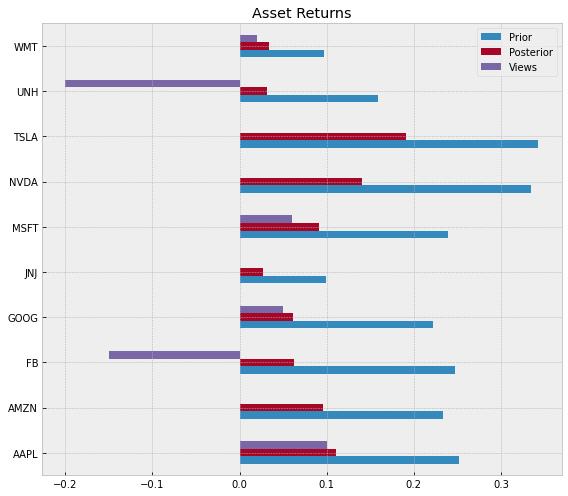

In [47]:
rets_df.plot(kind='barh', figsize=(8, 7), title='Asset Returns')
plt.tight_layout()
plt.show()

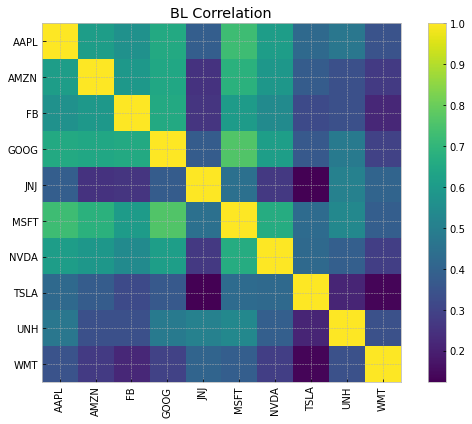

In [48]:
S_bl = bl.bl_cov()
ax = plotting.plot_covariance(S_bl, plot_correlation=True)
ax.set_title("BL Correlation")
ax.figure.set_size_inches(8, 6)
plt.tight_layout()
plt.show()

## Portfolio Allocation

In [49]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg, gamma=0.3)
ef.min_volatility()
weights = ef.clean_weights()

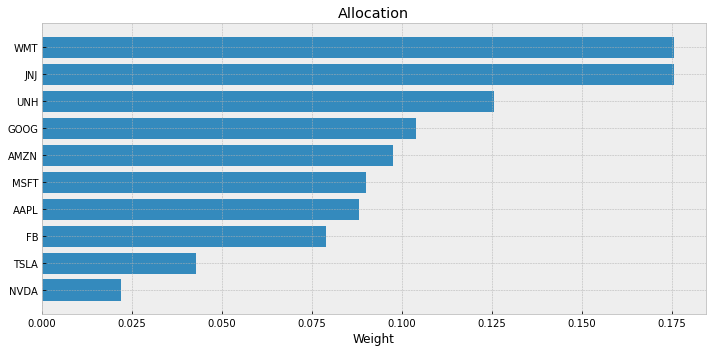

In [50]:
ax = plotting.plot_weights(weights)
ax.figure.set_size_inches(10, 5)
ax.set_title("Allocation")
plt.tight_layout()
plt.show()

## Post-processing

In [51]:
data.iloc[-1]

AAPL     156.770004
AMZN    2328.139893
FB       208.279999
GOOG    2334.929932
JNJ      176.759995
MSFT     277.350006
NVDA     188.440002
TSLA     873.280029
UNH      494.720001
WMT      152.740005
Name: 2022-05-05 00:00:00, dtype: float64

In [52]:
da = DiscreteAllocation(weights, data.iloc[-1], total_portfolio_value=1e6)

In [53]:
alloc, leftover = da.lp_portfolio(verbose=True)

Funds remaining: 75.34
AAPL: allocated 0.088, desired 0.088
AMZN: allocated 0.098, desired 0.098
FB: allocated 0.079, desired 0.079
GOOG: allocated 0.103, desired 0.104
JNJ: allocated 0.176, desired 0.175
MSFT: allocated 0.090, desired 0.090
NVDA: allocated 0.022, desired 0.022
TSLA: allocated 0.043, desired 0.043
UNH: allocated 0.126, desired 0.126
WMT: allocated 0.176, desired 0.176
Allocation has RMSE: 0.000


In [54]:
total_value = 0
for t, s in alloc.items():
    value = s * data.iloc[-1][t]
    total_value += value
    print(f"{t:5s} | {str(s):5s} shares | $ {value:.2f}")
print('-'*40)
print(f"Asset Value $ {total_value:.2f}")
print('-'*40)
print(f"Leftover $ {leftover:.2f}")
print('-'*40)
print(f"TOTAL VALUE $ {total_value + leftover:.2f}")
print('='*40)

AAPL  | 563   shares | $ 88261.51
AMZN  | 42    shares | $ 97781.88
FB    | 380   shares | $ 79146.40
GOOG  | 44    shares | $ 102736.92
JNJ   | 993   shares | $ 175522.67
MSFT  | 325   shares | $ 90138.75
NVDA  | 118   shares | $ 22235.92
TSLA  | 49    shares | $ 42790.72
UNH   | 254   shares | $ 125658.88
WMT   | 1150  shares | $ 175651.01
----------------------------------------
Asset Value $ 999924.66
----------------------------------------
Leftover $ 75.34
----------------------------------------
TOTAL VALUE $ 1000000.00


# Heirarchical Risk Parity

In [55]:
tickers = ["BLK", "BAC", "AAPL", "TM", "WMT",
           "JD", "INTU", "MA", "UL", "CVS",
           "DIS", "AMD", "NVDA", "PBI", "TGT"]
data = yf.download(tickers=tickers, period='5y', interval='1d')['Adj Close']
print(data.shape)
data.tail()

[*********************100%***********************]  15 of 15 completed
(1258, 15)


,AAPL,AMD,BAC,BLK,CVS,DIS,INTU,JD,MA,NVDA,PBI,TGT,TM,UL,WMT
Date,,,,,,,,,,,,,,,
2022-04-28,163.639999,89.639999,36.810001,650.969971,100.849998,115.290001,444.579987,57.810001,378.829987,197.820007,5.32,236.389999,172.970001,46.160000,156.210007
2022-04-29,157.649994,85.519997,35.680000,624.679993,96.129997,111.629997,418.750000,61.660000,363.380005,185.470001,5.27,228.649994,171.000000,46.259998,152.990005
2022-05-02,157.960007,89.839996,36.139999,624.799988,96.500000,113.500000,427.010010,63.369999,359.040009,195.330002,5.05,229.779999,170.690002,45.639999,151.979996
2022-05-03,159.479996,91.129997,37.130001,631.059998,95.980003,113.550003,430.839996,62.169998,357.790009,196.020004,5.06,232.539993,172.059998,45.650002,152.509995
2022-05-04,166.020004,99.419998,38.619999,665.229980,100.570000,116.190002,447.920013,63.180000,368.519989,203.339996,5.10,237.429993,174.850006,45.900002,154.619995


In [56]:
rets = expected_returns.returns_from_prices(data)

In [57]:
# not need to input covariance
# different linkage method results in different weights

linkage_methods = ['single', 'complete', 'average', 'weighted', 'centroid', 'median', 'ward']

# get hrp for different method
hrp_models = []
for method in linkage_methods:
    hrp = HRPOpt(returns=rets)
    hrp.optimize(linkage_method=method)
    hrp_models.append(hrp)

# retreive weights
hrp_weights = []
for hrp in hrp_models:
    hrp_weights.append(hrp.clean_weights())
    
# combine all weights to single dataframe
hrp_weights_df = pd.DataFrame()
for method, weight in zip(linkage_methods, hrp_weights):
    w_df = pd.DataFrame.from_dict(weight, orient='index', columns=[method])
    hrp_weights_df = pd.concat([hrp_weights_df, w_df], axis=1)

In [58]:
hrp_weights_df

,single,complete,average,weighted,centroid,median,ward
AAPL,0.05274,0.05633,0.04555,0.05633,0.04817,0.04911,0.05354
AMD,0.01413,0.03018,0.02606,0.03018,0.02542,0.01760,0.01846
BAC,0.03348,0.04232,0.03565,0.04232,0.03306,0.03662,0.03980
BLK,0.04474,0.05655,0.04765,0.05655,0.04418,0.04894,0.05318
CVS,0.08180,0.08466,0.10738,0.08941,0.10105,0.07919,0.07779
DIS,0.05698,0.06610,0.05569,0.06610,0.05811,0.07193,0.06216
INTU,0.03650,0.04743,0.03835,0.04743,0.03604,0.03992,0.04850
JD,0.03253,0.03840,0.03316,0.03840,0.03235,0.02239,0.03915
MA,0.03899,0.05066,0.04096,0.05066,0.03850,0.04264,0.06348
NVDA,0.01821,0.02277,0.01841,0.02277,0.01947,0.01985,0.02379


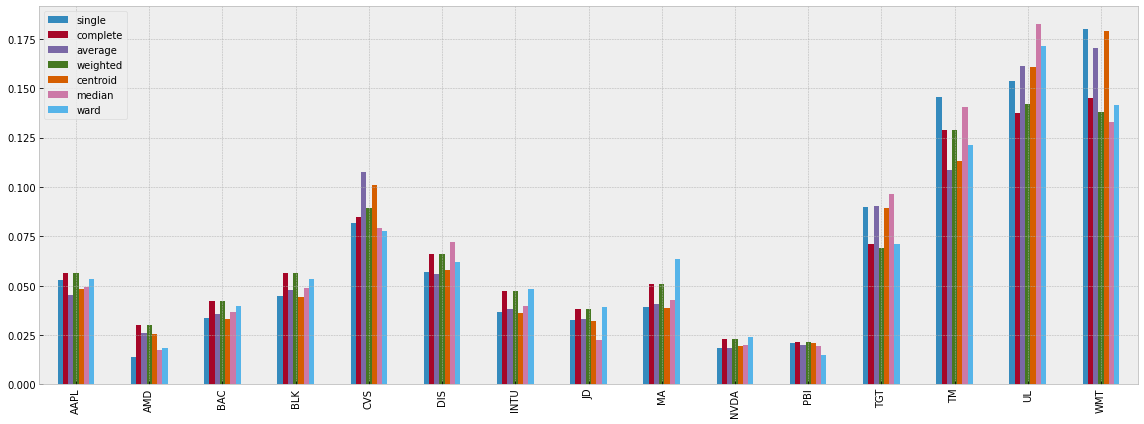

In [59]:
hrp_weights_df.plot(kind='bar', figsize=(16, 6))
plt.tight_layout()
plt.show()

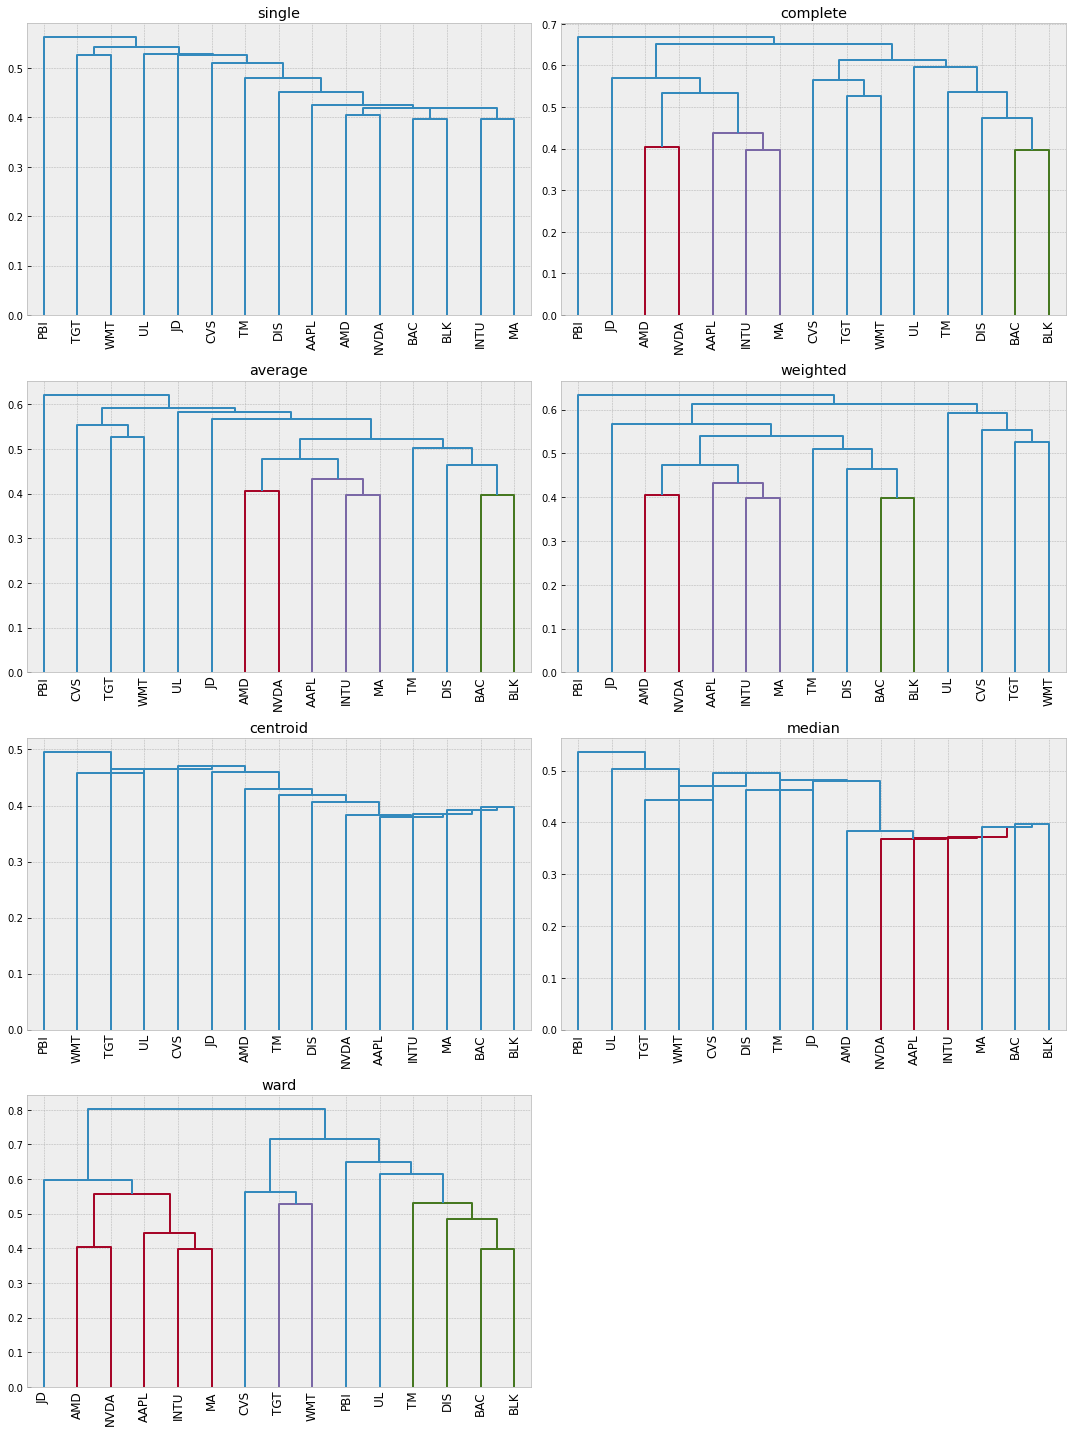

In [60]:
# Dendogram

plt.figure(figsize=(15, 20))
for i, hrp in enumerate(hrp_models):
    ax = plt.subplot(int(np.ceil(len(hrp_models)/2)), 2, i+1)
    plotting.plot_dendrogram(hrp, ax=ax)
    ax.set_title(linkage_methods[i])

In [61]:
for method, hrp in zip(linkage_methods, hrp_models):
    print(f"***** {method} *****")
    hrp.portfolio_performance(verbose=True)
    print('-'*50)

***** single *****
Expected annual return: 18.6%
Annual volatility: 18.2%
Sharpe Ratio: 0.91
--------------------------------------------------
***** complete *****
Expected annual return: 19.7%
Annual volatility: 19.1%
Sharpe Ratio: 0.93
--------------------------------------------------
***** average *****
Expected annual return: 19.0%
Annual volatility: 18.5%
Sharpe Ratio: 0.92
--------------------------------------------------
***** weighted *****
Expected annual return: 19.5%
Annual volatility: 19.1%
Sharpe Ratio: 0.92
--------------------------------------------------
***** centroid *****
Expected annual return: 19.0%
Annual volatility: 18.4%
Sharpe Ratio: 0.92
--------------------------------------------------
***** median *****
Expected annual return: 18.4%
Annual volatility: 18.4%
Sharpe Ratio: 0.89
--------------------------------------------------
***** ward *****
Expected annual return: 19.0%
Annual volatility: 18.8%
Sharpe Ratio: 0.90
--------------------------------------